In [1]:
%reload_ext autoreload

In [2]:
%autoreload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mvlearn.embed import MCCA
import umap


from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_target_prediction
from src.constants import RANDOM_STATE
from src.pipelines import classification_pipeline, regression_pipeline, cv_regression_pipeline, cox_regression_pipeline, cox_regression_pipeline_cv
from src.autoencoder import EncoderPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2024-05-21 17:00:34.050625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 17:00:34.087027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 17:00:34.087065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 17:00:34.088263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 17:00:34.095376: I tensorflow/core/platform/cpu_feature_guar

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
survival_data_breast = pd.read_csv('data/breast/survival_data_breast.csv')
dna_breast = pd.read_csv('data/breast/expression_data_breast.csv', index_col=[0])

rna_breast = pd.read_csv('data/breast/mirna_data_breast.csv', index_col=[0])

methylation_breast = pd.read_csv('data/breast/methylation_data_breast.csv', index_col=[0])

mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast.csv')

assert (survival_data_breast['PatientID'] == mofa_data_breast['sample'].drop_duplicates()).all()
assert (clinical_data_breast['sampleID'] == mofa_data_breast['sample'].drop_duplicates()).all()

In [4]:
N_FACTORS = 20

Из клинических данных вручную отобраны фичи, которые не связаны с таргетом, содержат более 80% непустых данных и более 1 уникального значения, и которые не являются техническими (названия файлов, идентификаторы и прочее)

In [5]:
CATEGORICAL_CLINICAL_FEATURES = [
                                 'anatomic_neoplasm_subdivision', 
                                 'axillary_lymph_node_stage_method_type',
                                 'breast_carcinoma_estrogen_receptor_status',
                                 'breast_carcinoma_progesterone_receptor_status',
                                 'breast_carcinoma_surgical_procedure_name',
                                 'gender',
                                 'histological_type',
                                 'history_of_neoadjuvant_treatment',
                                 'icd_10',
                                 'icd_o_3_histology',
                                 'icd_o_3_site',
                                 'initial_pathologic_diagnosis_method',
                                 'lab_proc_her2_neu_immunohistochemistry_receptor_status',
                                 'margin_status',
                                 'menopause_status',
                                 'new_tumor_event_after_initial_treatment',
                                 'oct_embedded',
                                 'pathologic_M',
                                 'pathologic_N',
                                 'pathologic_T',
                                 'pathologic_stage',
                                 'person_neoplasm_cancer_status',
                                 'primary_lymph_node_presentation_assessment',
                                 'radiation_therapy',
                                 'system_version',
                                 'tissue_prospective_collection_indicator',
                                 'tissue_retrospective_collection_indicator',
                                 'tissue_source_site']
NUMERICAL_CLINICAL_FEATURES = ['age_at_initial_pathologic_diagnosis',
                               'initial_weight', 'lymph_node_examined_count', 'number_of_lymphnodes_positive_by_he']
N_CATEGORICAL_CLINICAL = len(CATEGORICAL_CLINICAL_FEATURES)
N_NUMERIC_CLINICAL = len(NUMERICAL_CLINICAL_FEATURES)

In [6]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in CATEGORICAL_CLINICAL_FEATURES:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features.head()

,age_at_initial_pathologic_diagnosis,initial_weight,lymph_node_examined_count,number_of_lymphnodes_positive_by_he,anatomic_neoplasm_subdivision,axillary_lymph_node_stage_method_type,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,breast_carcinoma_surgical_procedure_name,gender,...,pathologic_N,pathologic_T,pathologic_stage,person_neoplasm_cancer_status,primary_lymph_node_presentation_assessment,radiation_therapy,system_version,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site
0,55.0,60.0,13.0,4.0,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,NX,TX,Stage X,WITH TUMOR,YES,NO,6th,NO,YES,3C
1,50.0,120.0,15.0,1.0,Right Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Lumpectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,YES,6th,NO,YES,3C
2,62.0,NaN,23.0,1.0,Right,missing,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,NO,7th,NO,YES,3C
3,52.0,140.0,2.0,0.0,Right,Sentinel node biopsy alone,Positive,Positive,Simple Mastectomy,FEMALE,...,N0 (i+),T1c,Stage IA,TUMOR FREE,YES,NO,7th,NO,YES,3C
4,50.0,770.0,14.0,4.0,Left|Left Upper Outer Quadrant,Axillary lymph node dissection alone,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N2a,T2,Stage IIIA,TUMOR FREE,YES,NO,7th,YES,NO,4H


In [7]:
X_all = np.hstack([dna_breast.values, rna_breast.values, methylation_breast.values])
X_all_sep = [dna_breast.values, rna_breast.values, methylation_breast.values]


y_all = survival_data_breast['Survival'].values
death = survival_data_breast['Death'].values

### Обучаем модели факторизации

In [8]:
pipeline_base_args_cv = [X_all, y_all, clinical_features, death, RANDOM_STATE,  X_all.shape[1],
                    N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

pipeline_args_cv = [X_all, y_all, clinical_features, death, RANDOM_STATE, N_FACTORS,
                    N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

cox_pipeline_args_cv = [X_all, y_all, clinical_features, death, RANDOM_STATE, N_FACTORS, NUMERICAL_CLINICAL_FEATURES, CATEGORICAL_CLINICAL_FEATURES]


## Регрессия: предсказание survival

### Бейзлайн: без факторизации

In [9]:
%autoreload

base_metrics = cv_regression_pipeline(None, *pipeline_base_args_cv, plot_feat_imp=False)
m_f_base, m_c_base, c_f_base, c_c_base = base_metrics.values()

,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,462.066662,327.281897,0.627358,0.490566
Разбиение 2,2624.087444,1275.033501,0.404762,0.464286
Разбиение 3,1774.829204,1488.577159,0.481283,0.379679
Разбиение 4,175.559576,116.009438,0.627907,0.790698
Разбиение 5,1322.104019,690.486239,0.670588,0.664706
Разбиение 6,715.102937,384.615134,0.508621,0.724138
Разбиение 7,133.648595,89.788066,0.683117,0.664935
Разбиение 8,106.840128,95.194946,0.406780,0.220339
Разбиение 9,238.739646,156.462594,0.530726,0.709497
Разбиение 10,139.172965,101.553902,0.609756,0.697561


### MOFA


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='DNA' with N=620 samples and D=1280 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1148 features...
Loaded group='single_group' view='RNA' with N=620 samples and D=182 features...


Model options:
- Automatic Relevan

,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,472.272353,180.819537,0.726415,0.471698
Разбиение 2,4042.402185,1359.474201,0.595238,0.488095
Разбиение 3,1299.463897,533.432536,0.524064,0.497326
Разбиение 4,185.225372,94.795028,0.604651,0.674419
Разбиение 5,1222.740626,367.664845,0.723529,0.735294
Разбиение 6,634.238291,272.082136,0.439655,0.758621
Разбиение 7,126.077800,65.870816,0.605195,0.711688
Разбиение 8,126.038205,96.449666,0.559322,0.271186
Разбиение 9,242.070949,122.680490,0.525140,0.703911
Разбиение 10,162.632333,91.417741,0.263415,0.687805


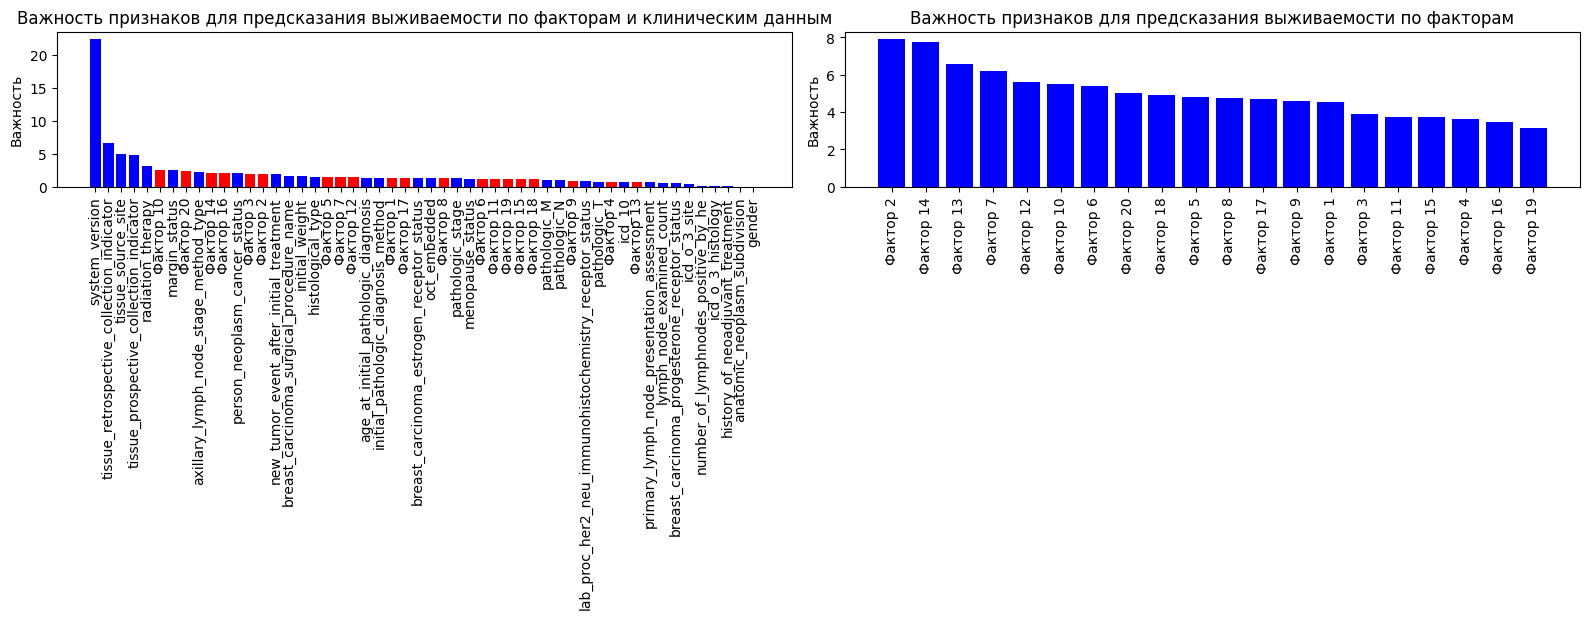

In [10]:
%autoreload

mofa_metrics = cv_regression_pipeline(train_mofa, *pipeline_args_cv, mofa_dataset=mofa_data_breast)
m_f_mofa, m_c_mofa, c_f_mofa, c_c_mofa = mofa_metrics.values()

### MCCA

,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,484.400039,177.754433,0.500000,0.424528
Разбиение 2,2708.338935,1327.181650,0.583333,0.273810
Разбиение 3,2093.797758,1339.047209,0.497326,0.518717
Разбиение 4,165.846407,93.566138,0.720930,0.651163
Разбиение 5,1413.869266,555.641271,0.523529,0.688235
Разбиение 6,807.552050,301.523630,0.616379,0.758621
Разбиение 7,130.293661,64.975662,0.755844,0.724675
Разбиение 8,119.816831,86.535561,0.604520,0.282486
Разбиение 9,242.520916,112.509886,0.620112,0.751397
Разбиение 10,162.026901,86.617354,0.497561,0.575610


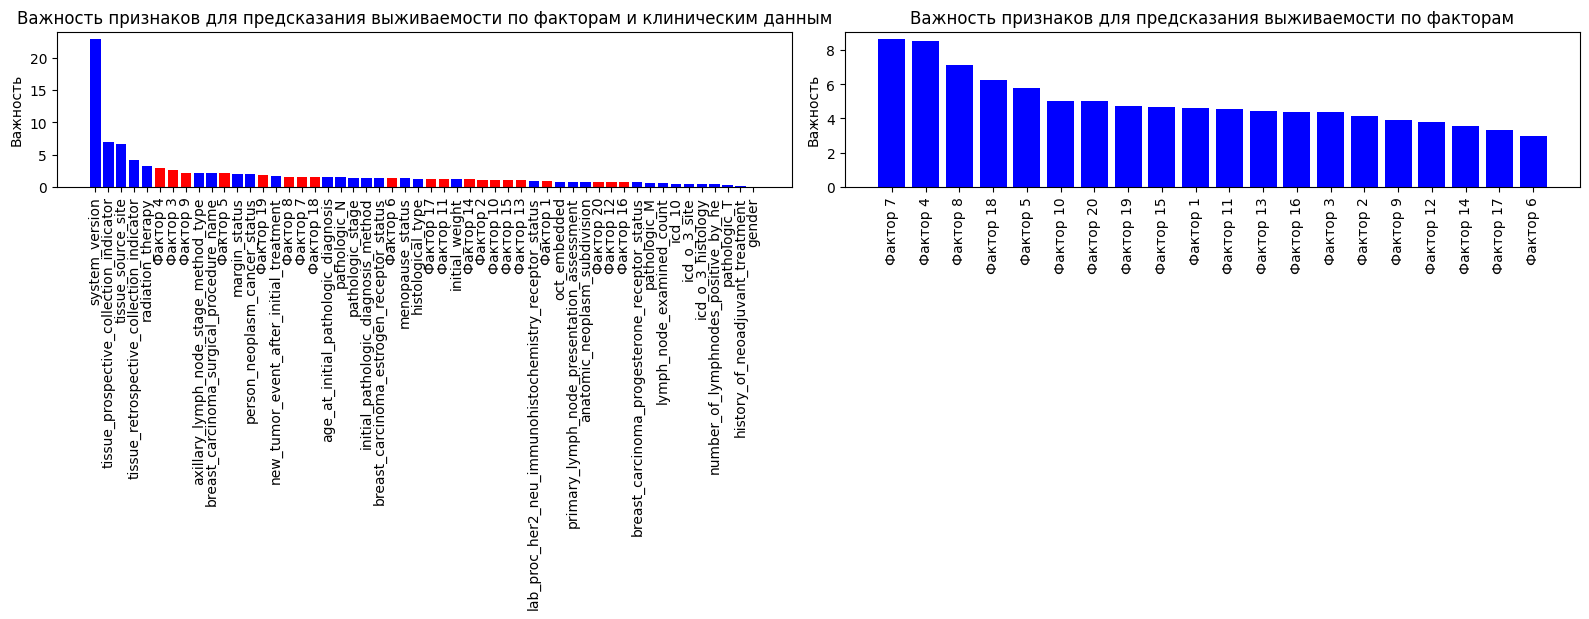

In [11]:
%autoreload

cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_metrics = cv_regression_pipeline(cca, X_all_sep, *pipeline_args_cv[1:])
m_f_mcca, m_c_mcca, c_f_mcca, c_c_mcca = mcca_metrics.values()

### PCA

,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,492.177501,193.732432,0.712264,0.533019
Разбиение 2,3226.272339,1859.693293,0.535714,0.428571
Разбиение 3,2058.002681,746.828767,0.315508,0.556150
Разбиение 4,187.310755,102.024831,0.720930,0.720930
Разбиение 5,1847.562196,105.249182,0.523529,0.794118
Разбиение 6,728.293162,341.549155,0.534483,0.780172
Разбиение 7,118.170460,67.944805,0.709091,0.732468
Разбиение 8,117.015370,85.481174,0.502825,0.378531
Разбиение 9,229.589011,111.653806,0.553073,0.748603
Разбиение 10,153.830600,86.202488,0.370732,0.712195


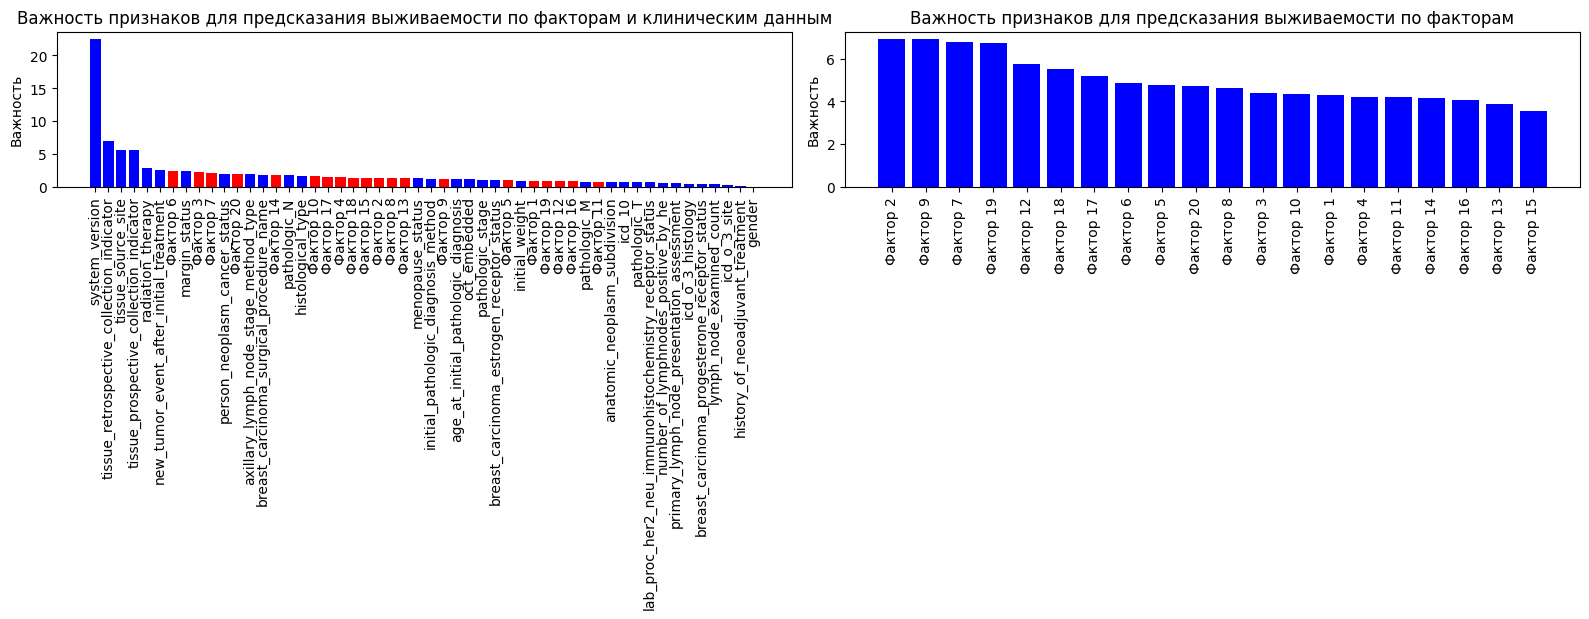

In [12]:
%autoreload

pca = PCA(n_components=N_FACTORS)
pca_metrics = cv_regression_pipeline(pca, *pipeline_args_cv)
m_f_pca, m_c_pca, c_f_pca, c_c_pca = pca_metrics.values()

### UMAP

,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,483.186416,164.000571,0.500000,0.495283
Разбиение 2,1412.067660,934.856516,0.488095,0.404762
Разбиение 3,1817.084632,720.419585,0.657754,0.513369
Разбиение 4,143.762599,102.871593,0.534884,0.604651
Разбиение 5,1089.030145,605.271982,0.752941,0.700000
Разбиение 6,621.949678,286.864881,0.551724,0.806034
Разбиение 7,188.873638,61.189284,0.436364,0.703896
Разбиение 8,131.171789,81.449741,0.644068,0.322034
Разбиение 9,287.370599,136.534535,0.469274,0.751397
Разбиение 10,159.054224,93.133914,0.634146,0.658537


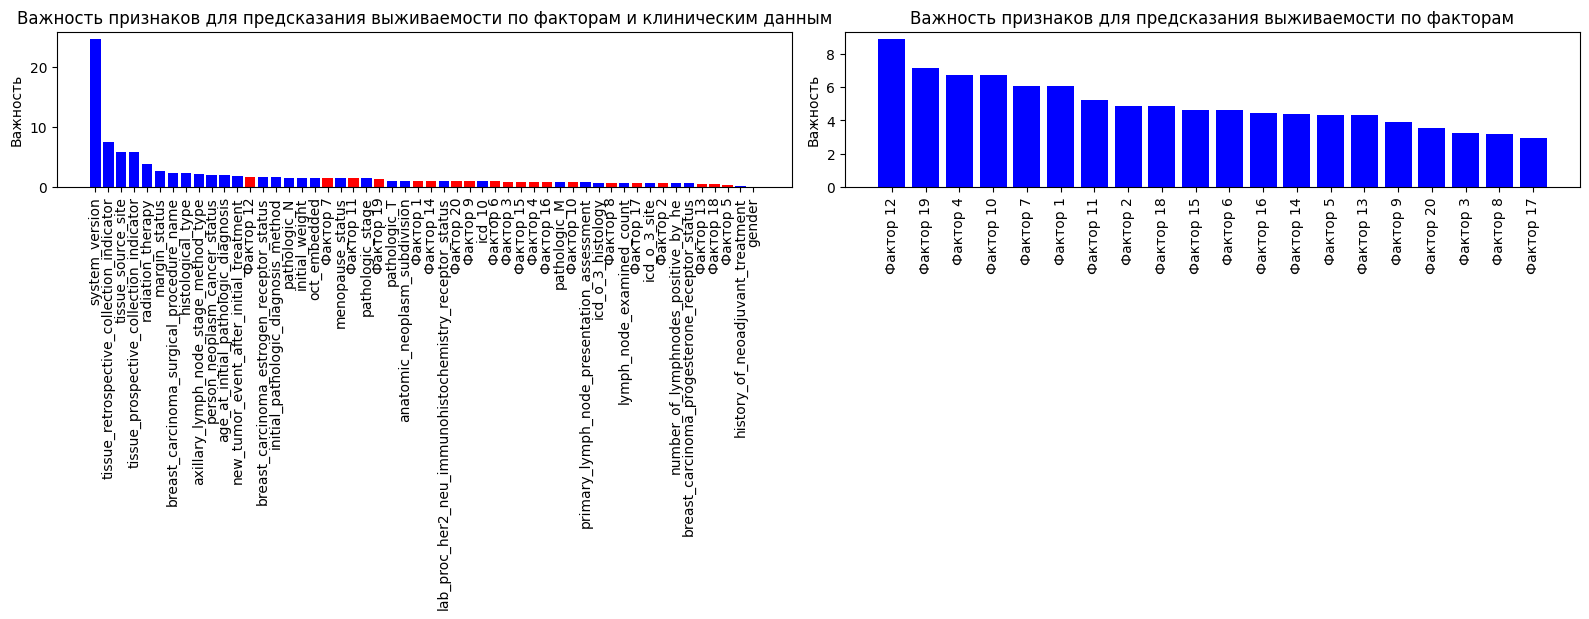

In [13]:
umap_reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_metrics = cv_regression_pipeline(umap_reducer, *pipeline_args_cv)
m_f_umap, m_c_umap, c_f_umap, c_c_umap = umap_metrics.values()

### Base Autoencoder

Base Autoencoder - модель из статьи Deep Learning–Based Multi-Omics Integration Robustly Predicts Survival in Liver Cancer: 1 энкодер для всех 3х модальностей, сконкатенированных друг с другом, 1 скрытый линейный слой, ф-ция активации - tanh, dropout 0.5Base Autoencoder - модель из статьи Deep Learning–Based Multi-Omics Integration Robustly Predicts Survival in Liver Cancer: 1 энкодер для всех 3х модальностей, сконкатенированных друг с другом, 1 скрытый линейный слой, ф-ция активации - tanh, dropout 0.5

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lisabeth-shevtsova (liza-i-pivko). Use `wandb login --relogin` to force relogin


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,529.800526,328.490771,0.551887,0.514151
Разбиение 2,2271.661753,791.392896,0.654762,0.392857
Разбиение 3,1561.897811,603.259976,0.406417,0.574866
Разбиение 4,179.287836,97.833274,0.558140,0.465116
Разбиение 5,1900.940687,446.791731,0.423529,0.676471
Разбиение 6,750.706268,190.761297,0.456897,0.762931
Разбиение 7,180.756099,65.925923,0.441558,0.693506
Разбиение 8,114.701708,94.965042,0.491525,0.242938
Разбиение 9,216.701927,117.870384,0.477654,0.770950
Разбиение 10,170.625416,79.961864,0.702439,0.765854


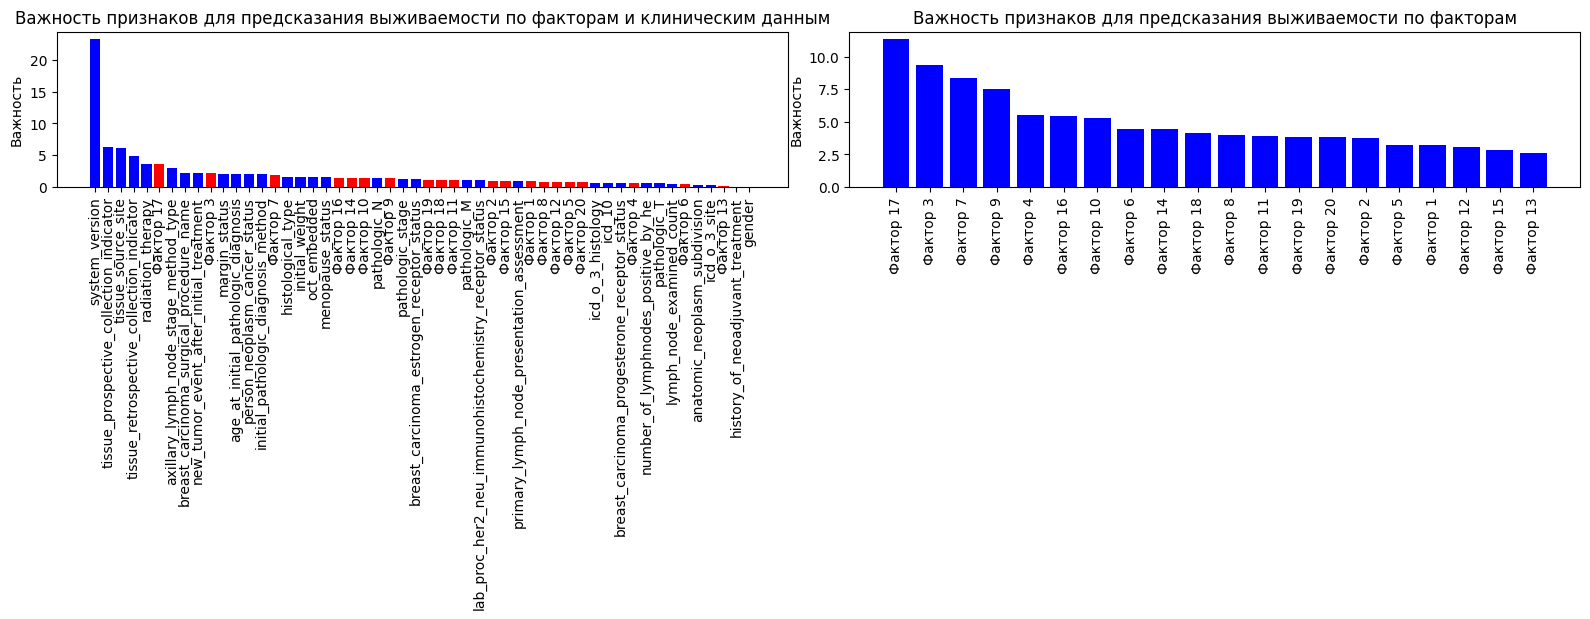

In [14]:
%autoreload

base_auto_metrics = cv_regression_pipeline(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:])
m_f_base_auto, m_c_base_auto, c_f_base_auto, c_c_base_auto = base_auto_metrics.values()

### Triple Autoencoder

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,"MAPE предсказания по факторам, %","MAPE предсказания по факторам и клиническим данным, %",C-индекс (цензурированный) предсказания по факторам,C-индекс (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,800.317480,129.283511,0.535377,0.504717
Разбиение 2,2861.227791,1350.421545,0.619048,0.369048
Разбиение 3,3136.868305,992.702457,0.379679,0.561497
Разбиение 4,179.872051,98.268316,0.302326,0.627907
Разбиение 5,1371.076258,675.517399,0.529412,0.588235
Разбиение 6,530.376137,294.331639,0.456897,0.732759
Разбиение 7,155.093649,55.556838,0.350649,0.766234
Разбиение 8,161.221376,90.306300,0.505650,0.231638
Разбиение 9,189.105019,96.430340,0.405028,0.759777
Разбиение 10,141.389979,118.044781,0.302439,0.687805


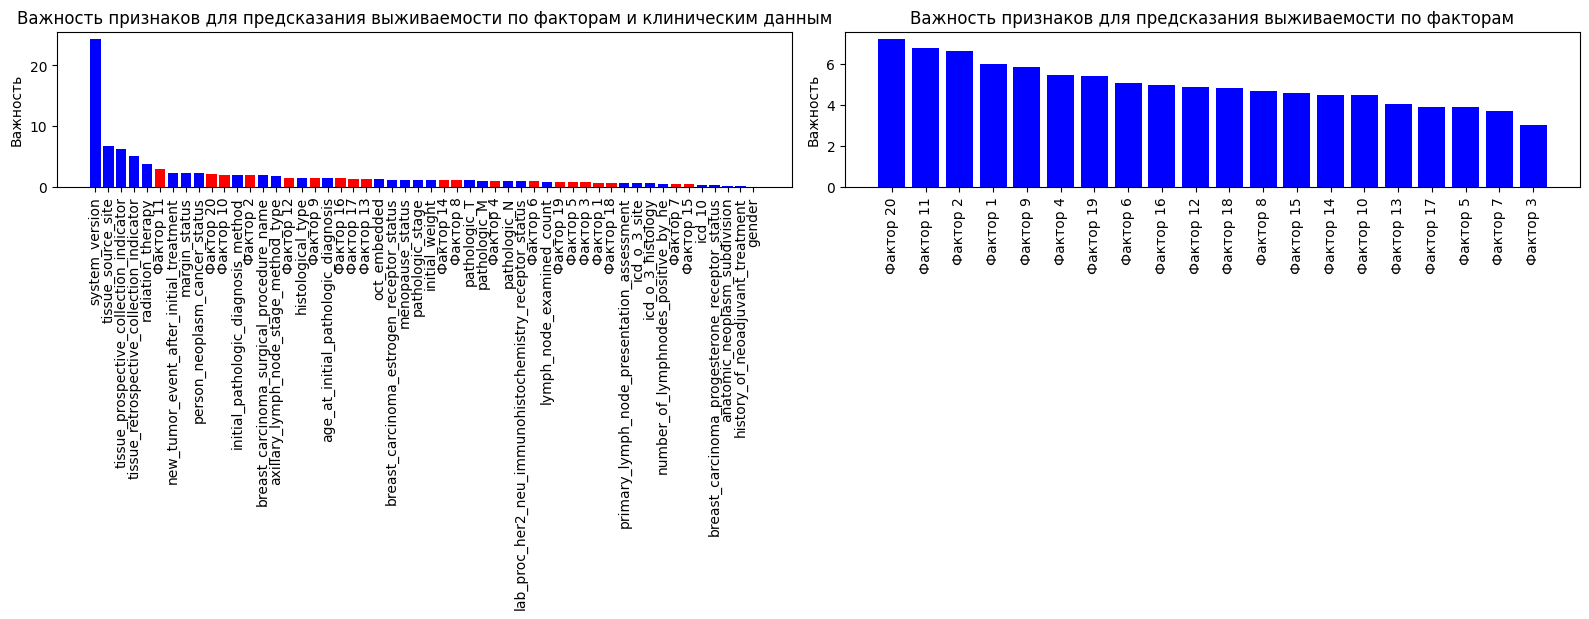

In [15]:
%autoreload

triple_auto_metrics = cv_regression_pipeline(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:], base_encoder=False)
m_f_triple_auto, m_c_triple_auto, c_f_triple_auto, c_c_triple_auto = triple_auto_metrics.values()

### Регрессия, результаты:

In [27]:
regr_results = pd.DataFrame({
    'MAPE предсказания по факторам, %': [m_f_base, m_f_pca, m_f_umap, m_f_mofa, m_f_mcca, m_f_base_auto, m_f_triple_auto],
    # 'MAPE предсказания по факторам и клиническим данным, %': [m_c_base, m_c_pca, m_c_pca, m_c_mofa, m_c_mcca, m_c_base_auto, m_c_triple_auto],
    'C-index (цензурированный) предсказания, по факторам': [c_f_base, c_f_pca, c_f_umap, c_f_mofa, c_f_mcca, c_f_base_auto, c_f_triple_auto],
    # 'C-index (цензурированный) предсказания, по факторам и клиническим данным': [c_c_base, c_c_pca, c_c_umap, c_c_mofa, c_c_mcca, c_c_base_auto, c_c_triple_auto]
}, index=['Без факторизации', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Базовый Автокодировщик', 'Тройной Автокодировщик'])

cols = regr_results.columns

regr_results['Среднее по методу'] = regr_results[cols[2:]].values.sum(axis=1) - regr_results[cols[:2]].values.sum(axis=1)
column_means = regr_results.iloc[:, :-1].mean(axis=0)
regr_results.loc['Среднее по всем методам'] = column_means.tolist() + ['-']

regr_results

,"MAPE предсказания по факторам, %","C-index (цензурированный) предсказания, по факторам",Среднее по методу
Без факторизации,769.215117,0.555090,-769.770207
PCA,915.822407,0.547815,-916.370222
UMAP,633.355138,0.566925,-633.922063
MOFA,851.316201,0.556662,-851.872864
MCCA,832.846276,0.591954,-833.43823
Базовый Автокодировщик,787.708003,0.516481,-788.224484
Тройной Автокодировщик,952.654805,0.438650,-953.093455
Среднее по всем методам,820.416850,0.539082,-


### *В задаче предсказания survival в по факторам, используя CatboostRegressor, лучше всего оказался Triple Autoencoder - по С-index censored*

## Регрессия: Cox model, предсказание risk score

### Бейзлайн: без факторизации

In [18]:
# %autoreload

# base_cox_metrics = cox_regression_pipeline_cv(None, *cox_pipeline_args_cv)
# c_f_base_cox, c_c_base_cox = base_cox_metrics.values()

### MOFA

In [19]:
%autoreload

mofa_cox_metrics = cox_regression_pipeline_cv(train_mofa, *cox_pipeline_args_cv, mofa_dataset=mofa_data_breast)
c_f_mofa_cox, c_c_mofa_cox = mofa_cox_metrics.values()



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        




Loaded group='single_group' view='DNA' with N=620 samples and D=1280 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1148 features...
Loaded group='single_group' view='RNA' with N=620 samples and D=182 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (DNA): gaussian
- View 1 (Methylation): gaussian
- View 2 (RNA): gaussian




######################################
## Training the model with seed 42 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in data/outputs/test_1716306314.7383275.hdf5...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###   

,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.570755,0.806604
Разбиение 2,0.654762,0.738095
Разбиение 3,0.657754,0.823529
Разбиение 4,0.976744,0.953488
Разбиение 5,0.905882,0.917647
Разбиение 6,0.715517,0.918103
Разбиение 7,0.631169,0.890909
Разбиение 8,0.497175,0.824859
Разбиение 9,0.754190,0.851955
Разбиение 10,0.721951,0.951220


### MCCA

In [20]:
%autoreload

cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_cox_metrics = cox_regression_pipeline_cv(cca, X_all_sep, *cox_pipeline_args_cv[1:])
c_f_mcca_cox, c_c_mcca_cox = mcca_cox_metrics.values()

,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.433962,0.844340
Разбиение 2,0.654762,0.642857
Разбиение 3,0.631016,0.850267
Разбиение 4,0.930233,0.930233
Разбиение 5,0.782353,0.917647
Разбиение 6,0.672414,0.892241
Разбиение 7,0.628571,0.859740
Разбиение 8,0.762712,0.830508
Разбиение 9,0.664804,0.865922
Разбиение 10,0.521951,0.887805


### PCA

In [21]:
%autoreload

pca = PCA(n_components=N_FACTORS)
pca_cox_metrics = cox_regression_pipeline_cv(pca, *cox_pipeline_args_cv)
c_f_pca_cox, c_c_pca_cox = pca_cox_metrics.values()

,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.509434,0.797170
Разбиение 2,0.654762,0.750000
Разбиение 3,0.631016,0.812834
Разбиение 4,0.976744,0.930233
Разбиение 5,0.900000,0.923529
Разбиение 6,0.711207,0.918103
Разбиение 7,0.610390,0.883117
Разбиение 8,0.463277,0.796610
Разбиение 9,0.726257,0.860335
Разбиение 10,0.770732,0.965854


### UMAP

In [22]:
umap_reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)


umap_cox_metrics = cox_regression_pipeline_cv(umap_reducer, *cox_pipeline_args_cv)
c_f_umap_cox, c_c_umap_cox = umap_cox_metrics.values()

,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.462264,0.839623
Разбиение 2,0.714286,0.678571
Разбиение 3,0.454545,0.796791
Разбиение 4,0.860465,0.953488
Разбиение 5,0.782353,0.882353
Разбиение 6,0.512931,0.905172
Разбиение 7,0.488312,0.857143
Разбиение 8,0.751412,0.841808
Разбиение 9,0.745810,0.863128
Разбиение 10,0.702439,0.931707


### Base Autoencoder

In [23]:
%autoreload

cox_base_autoencoder_metrics = cox_regression_pipeline_cv(EncoderPipeline, X_all_sep, *cox_pipeline_args_cv[1:])
c_f_base_auto_cox, c_c_base_auto_cox = cox_base_autoencoder_metrics.values()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.665094,0.863208
Разбиение 2,0.690476,0.642857
Разбиение 3,0.604278,0.711230
Разбиение 4,0.720930,0.906977
Разбиение 5,0.670588,0.923529
Разбиение 6,0.504310,0.887931
Разбиение 7,0.438961,0.838961
Разбиение 8,0.598870,0.847458
Разбиение 9,0.594972,0.812849
Разбиение 10,0.619512,0.931707


### Triple Autoencoder

In [24]:
cox_triple_auto_metrics = cox_regression_pipeline_cv(EncoderPipeline, X_all_sep, *cox_pipeline_args_cv[1:], base_encoder=False)
c_f_triple_auto_cox, c_c_triple_auto_cox = cox_triple_auto_metrics.values()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным
Разбиение 1,0.556604,0.863208
Разбиение 2,0.738095,0.690476
Разбиение 3,0.454545,0.855615
Разбиение 4,0.488372,0.813953
Разбиение 5,0.452941,0.852941
Разбиение 6,0.590517,0.909483
Разбиение 7,0.651948,0.890909
Разбиение 8,0.762712,0.881356
Разбиение 9,0.768156,0.913408
Разбиение 10,0.600000,0.843902


In [25]:
# def new_func():
#     cox_regr_results = pd.DataFrame({
#     'C-index (цензурированный) предсказания по факторам': [c_f_base_cox, c_f_pca_cox, c_f_umap_cox, c_f_mofa_cox, c_f_mcca_cox, c_f_base_auto_cox, c_f_triple_auto_cox],
#     'C-index (цензурированный) предсказания по факторам и клиническим данным': [c_c_base_cox, c_c_pca_cox, c_c_umap_cox, c_c_mofa_cox, c_c_mcca_cox, c_c_base_auto_cox, c_c_triple_auto_cox]
# }, index=['Без факторизации', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Базовый автокодировщик', 'Тройной автокодировщик'])

#     cox_regr_results['Method Average'] = cox_regr_results.mean(axis=1)
#     means = cox_regr_results.iloc[:, :-1].mean(axis=0)
#     cox_regr_results.loc['All Methods Average'] = means.tolist() + ['-']

#     cox_regr_results.to_csv('data/coxregression-res.csv')

#     cox_regr_results

# new_func()

In [26]:
cox_regr_results = pd.DataFrame({
    'C-index (цензурированный) предсказания по факторам': [c_f_pca_cox, c_f_umap_cox, c_f_mofa_cox, c_f_mcca_cox, c_f_base_auto_cox, c_f_triple_auto_cox],
    'C-index (цензурированный) предсказания по факторам и клиническим данным': [c_c_pca_cox, c_c_umap_cox, c_c_mofa_cox, c_c_mcca_cox, c_c_base_auto_cox, c_c_triple_auto_cox]
}, index=['PCA', 'UMAP', 'MOFA', 'MCCA', 'Базовый автокодировщик', 'Тройной автокодировщик'])

cox_regr_results['Method Average'] = cox_regr_results.mean(axis=1)
means = cox_regr_results.iloc[:, :-1].mean(axis=0)
cox_regr_results.loc['All Methods Average'] = means.tolist() + ['-']

# cox_regr_results.to_csv('data/coxregression-res.csv')

cox_regr_results

,C-index (цензурированный) предсказания по факторам,C-index (цензурированный) предсказания по факторам и клиническим данным,Method Average
PCA,0.695382,0.863779,0.77958
UMAP,0.647482,0.854979,0.75123
MOFA,0.708590,0.867641,0.788115
MCCA,0.668278,0.852156,0.760217
Базовый автокодировщик,0.610799,0.836671,0.723735
Тройной автокодировщик,0.606389,0.851525,0.728957
All Methods Average,0.656153,0.854458,-


### *В задаче предсказания survival в по факторам, используя Cox Regression, лучше всего PCA по С-index censored*